A remake of the bar-and-whisker plot of statistical significance for the RDA paper based on RDA_bars_with_whiskers, but rewritten in much better style and to take advantage of more efficient loading of data.

Minor to-dos:
* Turn off hashmarks on x-axis.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

%matplotlib inline

In [2]:
data_file = 'Data/decadal_stats.hdf'
results_df = pd.read_hdf(data_file)
results_df = results_df.sort_index().sort_index(axis=1)

In [60]:
#customized script that adds overbars to indicate time periods, and then on top of that a p-value for the significance of the change.
def addpvals(fig,ax,rects,errs_list,pvals_list):
    
    for rect1,rect2,rect3,errs,pvals in zip(rects[0],rects[1],rects[2],errs_list,pvals_list):
        
        rects = [rect1,rect2,rect3]
        heights = [ rect.get_height() + err for rect,err in zip(rects,errs) ]            
        height = max(heights[0],heights[1],heights[2])
        yax = ax.get_ylim()
        yhgt = yax[1]-yax[0]
        
        xx_l = [rect1.get_x() + .175,rect1.get_x() + .4375]
        xx_r = [rect1.get_x() + .525,rect1.get_x() + .6125]
        yy = [height + .01*yhgt, height + .13*yhgt]

        for x_l,x_r,y,pval in zip(xx_l,xx_r,yy,pvals):
            ax.annotate("a", color='White', xy=(x_l, y), xytext=(x_l, y + .02*yhgt), 
                fontsize=15, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=1.25, lengthB=.5', lw=1.0))

            ax.annotate("b", color='White', xy=(x_r, y), xytext=(x_r, y + .02*yhgt), 
                fontsize=15, ha='center', va='bottom',
                arrowprops=dict(arrowstyle='-[, widthB=1.25, lengthB=.5', lw=1.0))

            #add lines
            plt.plot([x_l, (x_l+x_r)/2], [y + .008*yhgt, y + .04*yhgt], 'k-', lw=1)
            plt.plot([x_l, (x_l+x_r)/2], [y + .008*yhgt, y + .04*yhgt], 'k-', lw=1)

            #add p-value            
            plt.text((x_l+x_r)/2, y + .06*yhgt,'p=' + str(round(pval,3)), horizontalalignment = 'center', fontsize = 14)

In [61]:
N = 6               # number of data entries
ind = np.arange(N)              # the x locations for the groups
width1 = 0.35                   # bar width
width2 = 0.175

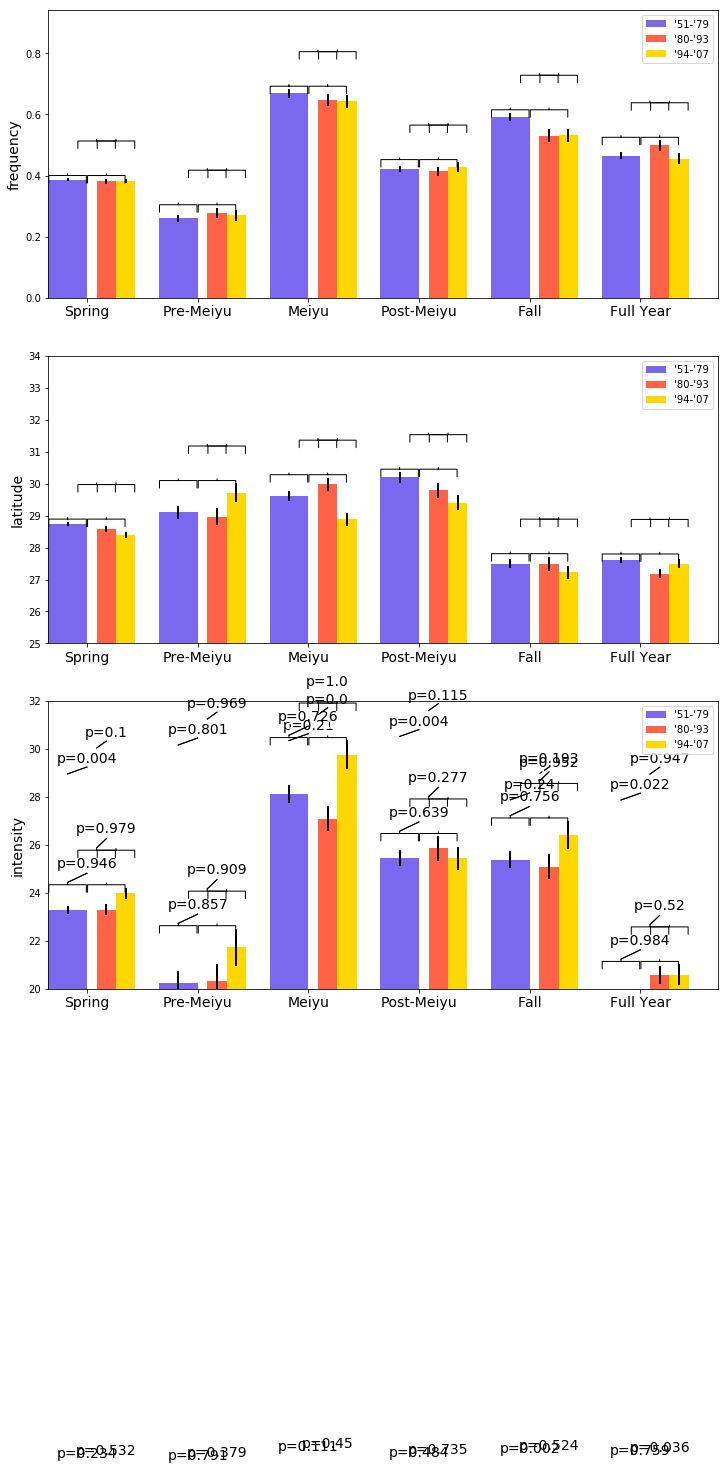

In [62]:
fig, axes = plt.subplots(3,1,figsize=(12,18), facecolor='w')

rects = []
colors = ['MediumSlateBlue','Tomato','Gold']
metrics = ['frequency','latitude','intensity']
my_error_kw={'ecolor':'Black','linewidth':2}
periods = ['p1','p1','p2']
widths = [width1, width2, width2]
xpositions = (ind,ind+width1,ind+width1+width2)
year_tags = ['8007_5179','9407_8093','9407_8093']
yranges = [[0,.94],[25,34],[20,32]]

for met,ax,yrange in zip(metrics,axes,yranges):
    
    #list of all 3 bar plots for a given subpanel
    sub_rects = []
    
    for (color, p, width, xpos, yr_tag) in zip(colors, periods, widths, xpositions,year_tags):
        vals = results_df.loc[(met,'mean_'+p),(slice(None),yr_tag)].values
        errs = results_df.loc[(met,'std_'+p),(slice(None),yr_tag)].values
        sub_rects.append(ax.bar(xpos,vals,width,color=color,yerr=errs,error_kw=my_error_kw))
    
    ax.set_ylim([yrange[0],yrange[1]])
    ax.set_xlim([-.175,5.875])  
    ax.set_ylabel(met, fontsize=14)
    ax.set_xticks(xpositions[0] + width)
    ax.set_xticklabels(('Spring', 'Pre-Meiyu', 'Meiyu', 'Post-Meiyu', 'Fall','Full Year'),\
                        fontsize=14)
    ax.legend((sub_rects[0], sub_rects[1], sub_rects[2]), ("'51-'79", "'80-'93", "'94-'07"))
    
    rects.append(sub_rects)
    
    ## collect the right collection of errors and p-values necessary for plotting.
    sub_errs = []
    sub_pvals = []
    
    for season in list(results_df.columns.levels[0]):
        ## arrange errors
        bar_errs = []
        for (p, yr_tag) in zip(periods,year_tags):
            bar_errs.append(results_df.loc[(met,'std_'+p),(season,yr_tag)])
        sub_errs.append(bar_errs)
        
        sub_pvals.append(list(results_df.loc[(met,'pval'),(season,slice(None))].values))

    #add p-values to top of plots
    addpvals(fig,ax,sub_rects,sub_errs,sub_pvals)

In [29]:
list(results_df.columns.levels[0])

['all', 'fall', 'meiyu', 'post-meiyu', 'pre-meiyu', 'spring']